In [1]:
# Importing related import function
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image

# Defining the dataloader
This is the custom dataloader to load the values to the model.

In [2]:
show_image_size = True
class CustomImageDataset(Dataset):
    '''
    Custom dataloader. This will work only for the Crop Yeild Dataset we have in store.
    '''

    def __init__(self, train_data, yield_data, transform=None, target_transform=None):
        # self.df = pd.DataFrame(data=np.load(train_data, allow_pickle=True), columns=['Data'])
        # self.img_dir = img_dir
        self.data = np.load(train_data, allow_pickle=True)
        self.yield_values = np.load(yield_data,allow_pickle=True)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        # return len(self.yield_data)
        return len(self.data)

    def __getitem__(self, idx):
        image_temp = Image.fromarray(self.data[:,:,idx])
        if show_image_size:
            print(image_temp.size, end="\r")
        image = image_temp
        if self.transform:
            image = self.transform(image)
        yield_data = self.yield_values[idx]
        return image, yield_data

The custom paths for the crop yield data

In [3]:
weather_source = r'../Data/CropYield/Cleaned/Cleaned/norm_train_02292024.npy'
yield_source = r'../Data/CropYield/Cleaned/Cleaned/norm_yield_train.npy'

Loading data into the dataloader

In [4]:
from torch.utils.data import DataLoader

training_data = CustomImageDataset(train_data=weather_source, yield_data=yield_source, transform=ToTensor())
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

Validating if the data is loaded as expected

Feature batch shape: torch.Size([7, 1, 7, 214])
Labels batch shape: torch.Size([7, 1])


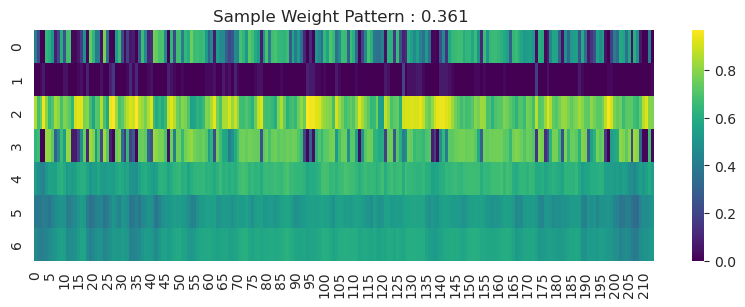

In [5]:
import seaborn as sns

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]

plt.figure(figsize=(10, 3))  # Adjust the figure size as needed
# plt.figure()  # Adjust the figure size as needed
# sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
sns.heatmap(img, annot=False, cmap='viridis', fmt=".2f")
plt.title(f"Sample Weight Pattern : {label.item():.3f} ", fontsize=12)
# Display the heatmap
plt.show()

# Defining the model
Creating and defining the resnet and resnext model for training.

In [6]:
import os
import sys 
notebook_path = os.getcwd()
print(notebook_path)
sys.path.append(os.path.dirname(notebook_path))

/home/jiztom/PycharmProjects/image-based-transformer/ResNetGradCAM


In [7]:
import datetime
import yaml
config_file =r'config/ResNet50_SGD_L1smooth_100_1e-04.yaml'
with open(config_file, "r") as yamlfile:
    data = yaml.load(yamlfile, Loader=yaml.FullLoader)
    print("Read successful")

Read successful


In [8]:
# dummy variable
test_debug = False
step = 0
val_step = 0
init_epoc = 0
#  Adding seed to get some re-train-ability
seed = int(data['seed'])
torch.manual_seed(seed)

# Data Source
data_source = data['csv_source']
normalize = bool(data['normalize'])
k_cross = int(data['k-cross'])

# Test Flags
test_flag = bool(data['test_flag'])
check_dataLoad = bool(data['check_dataloader'])
pretrain = bool(data['preTrain'])
show_image_size = bool(data['show_image_size'])

# hyper parameters
loss_func_name = data['loss_function']
batch_size = int(data['batch_size'])
learning_rate = float(data['learning_rate'])
epochs = int(data['epochs'])
pct_close = float(data['pct_close'])
optimizer_type = data['optimizer']

# Current model - architecture being run
model_structure = data['model_structure']
model_version = data['resnet']
model_savePath = data['model_path']

# Debug Mode
Debug = bool(data['Debug'])

# Variables
recover = bool(data['program_complete'])
last_save = data['last_save']
last_epoch = int(data['last_epoch'])

# Deciding which device to used
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print('Using {} device'.format(device))

if test_flag:
    epochs = 5

min_max = pd.Series(data=[1, 0], index=['max', 'min'])
# Creating a dynamic tensorboard filename
datetime_object = datetime.datetime.now()
date_time_clean = datetime_object.strftime('%m%d%Y_%H%M%S')
run_name = f'DataFlattening_{date_time_clean}_{model_structure}_{model_version}_{loss_func_name}_{batch_size}_' \
           f'{learning_rate}_{epochs}_{normalize}'

Using cuda:1 device


In [9]:
weather_data = np.load(weather_source, allow_pickle=True)
yield_data = np.load(yield_source, allow_pickle=True)

In [10]:
test = np.transpose(weather_data, (2,1,0))

In [11]:
print(weather_data.shape,yield_data.shape,test.shape)


(7, 214, 93028) (93028, 1) (93028, 214, 7)


In [12]:
data_temp = []
for i in range(len(test)):
    data_temp.append([test[i],yield_data[i]])
    
print(len(data_temp))

93028


In [13]:
data_temp[0]

[array([[0.33976   , 0.        , 0.505     , ..., 0.485     , 0.34611111,
         0.40683333],
        [0.02508   , 0.02222222, 0.8475    , ..., 0.45166667, 0.37      ,
         0.41027778],
        [0.64276   , 0.        , 0.6508    , ..., 0.48166667, 0.32722222,
         0.40038889],
        ...,
        [0.        , 0.08888889, 0.9025    , ..., 0.52555556, 0.47777778,
         0.4985    ],
        [0.12466   , 0.        , 0.78      , ..., 0.51333333, 0.40722222,
         0.45958333],
        [0.51842   , 0.        , 0.6713    , ..., 0.47944444, 0.39      ,
         0.42066667]]),
 array([0.26])]

In [14]:
data_df = pd.DataFrame(data_temp,columns=['Data','Yield_Data'])

In [15]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=k_cross)
kf.get_n_splits(data_df)
X_train, X_test = [], []
for train_index, test_index in kf.split(data_df):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    X_train.append(data_df.loc[train_index])
    X_test.append(data_df.loc[test_index])

data_change_epoch = int(epochs / k_cross)

TRAIN: 74422 TEST: 18606
TRAIN: 74422 TEST: 18606
TRAIN: 74422 TEST: 18606
TRAIN: 74423 TEST: 18605
TRAIN: 74423 TEST: 18605


In [16]:
X_test[0]


Data  \
0      [[0.33976, 0.0, 0.505, 0.6783333333333333, 0.4...   
1      [[0.41975999999999997, 0.0, 0.8538, 0.63333333...   
2      [[0.6936599999999999, 0.0, 0.7508, 0.8125, 0.5...   
3      [[0.461, 0.0, 0.5804, 0.84, 0.51, 0.3277777777...   
4      [[0.60942, 0.0, 0.7325, 0.7583333333333333, 0....   
...                                                  ...   
18601  [[0.09826, 0.0, 0.8088, 0.32416666666666666, 0...   
18602  [[0.064, 0.0, 0.7558, 0.18916666666666668, 0.4...   
18603  [[0.00034, 0.022222222222222223, 0.8521, 0.001...   
18604  [[0.00116, 0.022222222222222223, 0.9025, 0.005...   
18605  [[0.5705800000000001, 0.044444444444444446, 0....   

                  Yield_Data  
0                     [0.26]  
1      [0.36133333333333334]  
2      [0.49066666666666664]  
3       [0.4726666666666667]  
4       [0.5473333333333333]  
...                      ...  
18601   [0.5486666666666666]  
18602  [0.43600000000000005]  
18603                 [0.53]  
18604   [0.4846666666666667]  
18605  [0.32666666666666666]  

[18606 rows x 2 columns]

In [17]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(os.path.join(r'Tensorboard', run_name))

Loading related packages

In [18]:
from torchvision import models
import torchvision
from torchvision.models import *
from torch import nn

# Printing the pytorch and torch vision version.
print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")

PyTorch Version: 2.2.2
Torchvision Version: 0.17.2


In [19]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss

In [20]:
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1, 1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)

    def forward(self, x):
        return torch.cat([self.mp(x), self.ap(x)], 1)

In [21]:
# Defining the different loss functions for the model
if loss_func_name == 'CrossEntropyLoss':
    loss_fn = nn.CrossEntropyLoss()  # softmax output with n classes
elif loss_func_name == 'L1loss':
    loss_fn = nn.L1Loss()
elif loss_func_name == 'SmoothL1loss':
    loss_fn = nn.SmoothL1Loss()
elif loss_func_name == 'MSEloss':
    loss_fn = nn.MSELoss()
elif loss_func_name == 'RMSEloss':
    loss_fn = RMSELoss()
else:
    loss_fn = nn.L1Loss()

print(loss_fn)

SmoothL1Loss()


In [22]:
import torchvision.transforms as transforms
transform = transforms.Compose([
        # resize - not possibleunless the image is a square and there will be data loss.
        # transforms.Resize(32),
        # to-tensor
        transforms.ToTensor(),
        # normalize - not reuqired if the values has already been normalized
        # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

# ResNet Structure Definition
Defining the custom model for verification purposes

In [23]:
# model_structure = 'ResNet18'
class YieldModel(nn.Module):
    global pretrain, model_structure

    def __init__(self):
        super().__init__()
        layers = []
        if model_structure == 'ResNet34':
            layers = list(models.resnet34(weights=ResNet34_Weights.DEFAULT).children())[:-2]
        elif model_structure == 'ResNet18':
            layers = list(models.resnet18(weights=ResNet18_Weights.DEFAULT).children())[:-2]
        elif model_structure == 'ResNet50':
            layers = list(models.resnet50(weights=ResNet50_Weights.DEFAULT).children())[:-2]
        else:
            layers = list(models.resnet34(weights=ResNet34_Weights.DEFAULT).children())[:-2]
        layers[0] = nn.Conv2d(1, 64, kernel_size=(214, 7), stride=(2, 2), padding=(3, 3), bias=False)
        layers += [AdaptiveConcatPool2d(), nn.Flatten()]

        if model_structure == 'ResNet50':
            layers += [nn.BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
            layers += [nn.Dropout(p=0.60)]
            layers += [nn.Linear(4096, 1024, bias=True), nn.ReLU(inplace=True)]
            layers += [nn.Dropout(p=0.50)]

        # elif model_structure == "ResNet34":
        layers += [nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
        layers += [nn.Dropout(p=0.50)]
        layers += [nn.Linear(1024, 512, bias=True), nn.ReLU(inplace=True)]
        layers += [nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
        layers += [nn.Dropout(p=0.50)]
        layers += [nn.Linear(512, 16, bias=True), nn.ReLU(inplace=True)]
        layers += [nn.Linear(16, 1)]
        self.YieldModel = nn.Sequential(*layers)

    def forward(self, x):
        return self.YieldModel(x).squeeze(-1)

In [24]:
model = YieldModel().to(device)

In [25]:
# Defining the optimizer to be used in the model
if optimizer_type == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_type == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# elif optimizer_type == 'LARS':
#     optimizer = LARS.LARS([params for params in model.parameters() if params.requires_grad],
#                           lr=learning_rate,
#                           weight_decay=1e-6,
#                           exclude_from_weight_decay=["batch_normalization", "bias"],
#                           )
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [26]:
# train_dataset = CustomImageDataset(annotations_file=train_df, transform=transform)
# test_dataset = CustomImageDataset(annotations_file=test_df, transform=transform)

In [27]:
def init(pct_close_init):
    global pct_close
    pct_close = pct_close_init


def akkuracy(data_y, pred):
    global pct_close

    # pure Tensor, efficient version
    n_items = len(data_y)
    Y = data_y.squeeze(1) 
    # actual as [102] Tensor
    # predicted as [102,1] Tensor
    pred = pred.view(n_items)  # predicted as [102]
    # print(f"Y = {Y} and pred = {pred}")


    n_correct = torch.sum((torch.abs(torch.sub(pred, Y)) < torch.abs(pct_close * Y)))
    # n_correct = torch.abs(pred - Y) < torch.abs(pct_close * Y)
    acc = (n_correct.item() * 100.0 / n_items)  # scalar
    # acc = (len(n_correct) * 100.0 / n_items) 
    
    if test_debug:
        print(f"len of Y : {len(Y)}, pred length : {len(pred)}; pct_close : {pct_close}; n_items : {n_items}")
        print(f"n_correct : {(n_correct)} and current accuracy : {acc}")
    # torch.count_nonzero
    return acc


def minMax(x):
    return pd.Series(index=['min', 'max'], data=[x.min(), x.max()])


def normalized(x, min, max):
    return (x - min) / (max - min)


def denormalized(x, min, max):
    return (x * (max - min)) + min

In [28]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error

def train_loop(dataloader, test_dataloader, model, loss_fn, optimizer, epoch, minMax):
    global step, loss_func_name, val_step, device, writer, normalize
    size = len(dataloader.dataset)
    ep_loss = []
    ep_accuracy = []

    y_ground = []
    y_pred = []

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        # X = X.to(device).squeeze(1)
        X = X.to(device)
        y = y.to(device)
        # print(X.shape)
        # exit()
        pred = model(X)

        # pred = pred.squeeze(-1)
        # print(pred.shape)
        # exit()

        # print("this is the shape of both", y.shape, pred.shape)
        if loss_func_name == 'MSEloss' or 'RMSEloss':
            loss = loss_fn(pred, y.squeeze(1).to(torch.float32))
        else:
            loss = loss_fn(pred, y.squeeze(1))

        if normalize:
            norm_loss = (loss * (minMax['max'] - minMax['min'])) + minMax['min']
        else:
            norm_loss = loss

        accuracy = akkuracy(y, pred)
        
        if test_debug:
            exit()

        if not Debug:
            writer.add_scalar('Training/Loss', norm_loss, step)
            writer.add_scalar('Training/Accuracy', accuracy, step)

        step += 1
        ep_loss.append(loss.item())
        ep_accuracy.append(accuracy)

        y_ground.extend(y.to('cpu').detach().numpy())
        y_pred.extend(pred.to('cpu').detach().numpy())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            denorm_loss = (loss * (minMax['max'] - minMax['min'])) + minMax['min']
            if loss_func_name == 'MSEloss':
                if normalize:
                    # print(f"loss: {loss:>7f}  RMSE : {np.sqrt(loss):>7f} | loss(norm): {denorm_loss:>7f} "
                    #       f"RMSE(norm): {np.sqrt(denorm_loss):>7f} | accuracy: {accuracy:>7f} "
                    #       f"[{current:>5d}/{size:>5d}]")
                    print(f"loss: {loss:>7f}  RMSE : {np.sqrt(loss):>7f} | accuracy: {accuracy:>7f} "
                          f"[{current:>5d}/{size:>5d}]")
                else:
                    print(f"loss: {loss:>7f}  RMSE : {np.sqrt(loss):>7f} | accuracy: {accuracy:>7f} "
                          f"[{current:>5d}/{size:>5d}]")
            else:
                print(f"loss: {loss:>7f} | n-loss: {denorm_loss:>7f} | accuracy: {accuracy:>7f}"
                      f"[{current:>5d}/{size:>5d}]")
                
    r2_train = r2_score(y_ground, y_pred)
    keys = ['ActualGround', 'ActualPred']
    train_dict = dict.fromkeys(keys)
    train_dict['ActualGround'] = y_ground
    train_dict['AcutalPred'] = y_pred

    train_df = pd.DataFrame(train_dict)
    train_df['ActualGround'] = train_df['ActualGround'].apply(denormalized,
                                                             args=(minMax['min'], minMax['max']))
    train_df['ActualPred'] = train_df['AcutalPred'].apply(denormalized, args=(minMax['min'], minMax['max']))

    MSE_actual_train = mean_squared_error(train_df['ActualGround'], train_df['ActualPred'])
    RMSE_actual_train = np.sqrt(MSE_actual_train)
    MAE_actual_train = mae(train_df['ActualGround'], train_df['ActualPred'])

    with torch.no_grad():

        val_epoch_loss = []
        val_epoch_accuracy = []
        rms = 0
        model.eval()
        data_ground = []
        data_pred = []
        for X_val_batch, y_val_batch in test_dataloader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)

            # val_loss = loss_fn(y_val_pred, y_val_batch.squeeze(1))
            if loss_func_name == 'MSEloss':
                val_loss = loss_fn(y_val_pred, y_val_batch.squeeze(1).to(torch.float32))
            else:
                val_loss = loss_fn(y_val_pred, y_val_batch.squeeze(1))

            if normalize:
                norm_val_loss = (val_loss * (minMax['max'] - minMax['min'])) + minMax['min']
            else:
                norm_val_loss = val_loss

            # conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

            val_accuracy = akkuracy(y_val_batch, y_val_pred)

            data_ground.extend(y_val_batch.to('cpu').numpy())
            data_pred.extend(y_val_pred.to('cpu').numpy())

            if not Debug:
                writer.add_scalar('Evaluation/Loss', norm_val_loss, val_step)
                writer.add_scalar('Evaluation/Accuracy', val_accuracy, val_step)
            val_step += 1

            val_epoch_loss.append(val_loss.item())
            val_epoch_loss.append(val_loss.item())
            val_epoch_accuracy.append(val_accuracy)

    r2_val = r2_score(data_ground, data_pred)

    val_dict = dict.fromkeys(keys)
    val_dict['ActualGround'] = data_ground
    val_dict['ActualPred'] = data_pred

    val_df = pd.DataFrame(val_dict)

    val_df['ActualGround'] = val_df['ActualGround'].apply(denormalized, args=(minMax['min'], minMax['max']))
    val_df['ActualPred'] = val_df['ActualPred'].apply(denormalized, args=(minMax['min'], minMax['max']))

    MSE_actual_val = mean_squared_error(val_df['ActualGround'], val_df['ActualPred'])
    RMSE_actual_val = np.sqrt(MSE_actual_val)
    MAE_actual_val = mae(val_df['ActualGround'], val_df['ActualPred'])

    epoch_loss_avg = sum(ep_loss) / len(ep_loss)
    val_epoch_loss_avg = sum(val_epoch_loss) / len(val_epoch_loss)

    # if normalize:
    #     epoch_loss_avg = (epoch_loss_avg * (minMax['max'] - minMax['min'])) + minMax['min']
    #     val_epoch_loss_avg = (val_epoch_loss_avg * (minMax['max'] - minMax['min'])) + minMax['min']

    if loss_func_name == 'MSEloss':
        print(
            f'{loss_func_name} - Epoch {epoch + 1}: | Train Loss: MSE - {epoch_loss_avg:>7f} '
            f'RMSE - {np.sqrt(epoch_loss_avg):>7f} | '
            f'Val Loss: MSE - {val_epoch_loss_avg:>7f} '
            f'RMSE {np.sqrt(val_epoch_loss_avg):>7f} ')
    else:
        print(
            f'{loss_func_name} - Epoch {epoch + 1}: | Train Loss: {epoch_loss_avg:>7f} | '
            f'Val Loss: {val_epoch_loss_avg:>7f} ')
    print(f'R2 value  \t Train : {r2_train} | Validation : {r2_val}')
    print(f'Training \t RMSE : {RMSE_actual_train} MAE : {MAE_actual_train} \n'
          f'Validation \t RMSE : {RMSE_actual_val} MAE : {MAE_actual_val}')
    data_val = [RMSE_actual_train, MAE_actual_train, RMSE_actual_val, MAE_actual_val]
    return ep_loss, ep_accuracy, val_epoch_loss, val_epoch_accuracy, r2_train, r2_val, data_val

In [29]:
class CustomImageDataset2(Dataset):
    '''
    Custom dataloader. This will work only for the Crop Yeild Dataset we have in store.
    '''

    def __init__(self, annotations_file, transform=None, target_transform=None):
        # self.img_labels = annotations_file['Label']
        # self.img_dir = annotations_file['FilePath']
        self.img_dir = annotations_file['Data']
        self.transform = transform
        self.target_transform = target_transform
        self.yield_data = annotations_file['Yield_Data']

    def __len__(self):
        # return len(self.yield_data)
        return len(self.yield_data)

    def __getitem__(self, idx):
        global show_image_size
        # img_path = self.img_dir[idx]
        # print(img_path, self.img_labels[idx])
        # image = Image.open(img_path)
        # image_temp = Image.fromarray((image_crop(img_path)))
        image_temp = Image.fromarray(self.img_dir[idx])
        # image = transform.to_tensor(image_temp)
        if show_image_size:
            print(image_temp.size, end="\r")
        image = image_temp

        # image = self.image_crop(img_path)
        # label = self.img_labels.iloc[idx]

        if self.transform:
            image = self.transform(image)
        yield_data = self.yield_data[idx]
        return image, yield_data

In [30]:
for t in range(init_epoc, epochs):
    i = int(t / data_change_epoch)
    if t % data_change_epoch == 0:
        train_df, test_df = X_train[i], X_test[i]
        train_df = train_df.reset_index()
        test_df = test_df.reset_index()

        # Defining the dataset from the generated Dataframe
        train_dataset = CustomImageDataset2(annotations_file=train_df, transform=transform)
        test_dataset = CustomImageDataset2(annotations_file=test_df, transform=transform)
        print("Test and train dataset running successfully")

        # Defining the dataloader
        train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                       batch_size=batch_size,
                                                       shuffle=True)
        test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                      batch_size=batch_size,
                                                      shuffle=True)

    print(f"Epoch {t + 1}\n-------------------------------")
    print(f"Running with cross validation dataset {i + 1}")
    ep_loss, ep_accuracy, val_epoch_loss, val_epoch_accuracy, r2_train, r2_val, data_val = train_loop(
        train_dataloader,
        test_dataloader, model,
        loss_fn, optimizer, t,
        min_max)
    if not Debug:
        writer.add_scalar('Training/ep_loss', sum(ep_loss) / len(ep_loss), t)
        writer.add_scalar('Training/ep_accuracy', sum(ep_accuracy) / len(ep_accuracy), t)
        writer.add_scalar('Evaluation/ep_loss', sum(val_epoch_loss) / len(val_epoch_loss), t)
        writer.add_scalar('Evaluation/ep_accuracy', sum(val_epoch_accuracy) / len(val_epoch_accuracy), t)
        writer.add_scalar('Training/RMSE', data_val[0], t)
        writer.add_scalar('Training/MAE', data_val[1], t)
        writer.add_scalar('Evaluation/RMSE', data_val[2], t)
        writer.add_scalar('Evaluation/MAE', data_val[3], t)
        if r2_val < 0:
            writer.add_scalar('Training/r2_score', 0.0, t)
            writer.add_scalar('Training/r2_percent', 0.0, t)
            writer.add_scalar('Evaluation/r2_score', 0.0, t)
            writer.add_scalar('Evaluation/r2_percent', 0.0, t)
        else:
            writer.add_scalar('Training/r2_score', r2_train, t)
            writer.add_scalar('Training/r2_percent', r2_train * 100, t)
            writer.add_scalar('Evaluation/r2_score', r2_val, t)
            writer.add_scalar('Evaluation/r2_percent', r2_val * 100, t)
    
    if t % 10 == 0:
        # save model
        PATH = f'{model_savePath}/{run_name}_runtime_save.pth'
        torch.save(model.state_dict(), PATH)
        data['last_epoch'] = t
        data['last_save'] = PATH
        data['program_complete'] = False
        with open(config_file, "w") as yamlfile:
            documents = yaml.dump(data, yamlfile)
            print("YAML updated successfully")
print("Training Done!")
PATH = f'{model_savePath}/{run_name}_final.pth'
torch.save(model.state_dict(), PATH)

data['last_epoch'] = epochs
data['program_complete'] = True
data['last_save'] = PATH

with open(config_file, "w") as yamlfile:
    documents = yaml.dump(data, yamlfile)
    print("YAML updated successfully")

if not Debug:
    writer.close()

Test and train dataset running successfully
Epoch 1
-------------------------------
Running with cross validation dataset 1
loss: 0.052112 | n-loss: 0.052112 | accuracy: 7.031250[    0/74422]
loss: 0.046888 | n-loss: 0.046888 | accuracy: 3.906250[12800/74422]
loss: 0.040628 | n-loss: 0.040628 | accuracy: 7.812500[25600/74422]
loss: 0.034329 | n-loss: 0.034329 | accuracy: 11.718750[38400/74422]
loss: 0.036459 | n-loss: 0.036459 | accuracy: 10.156250[51200/74422]
loss: 0.039667 | n-loss: 0.039667 | accuracy: 14.062500[64000/74422]
SmoothL1loss - Epoch 1: | Train Loss: 0.042649 | Val Loss: 0.010308 
R2 value  	 Train : -6.693671687287947 | Validation : -0.7974511491676779
Training 	 RMSE : 0.2944757773238095 MAE : 0.21638782041036436 
Validation 	 RMSE : 0.14364193687574112 MAE : 0.11116888532669003
YAML updated successfully
Epoch 2
-------------------------------
Running with cross validation dataset 1
loss: 0.010054 | n-loss: 0.010054 | accuracy: 15.625000[    0/74422]
loss: 0.006385 | 

In [31]:
# %load_ext tensorboard
# %tensorboard --logdir "/home/jiztom/PycharmProjects/image-based-transformer/ResNetGradCAM/Tensorboard"

In [32]:
from torch.autograd import Variable
# import cv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradient = None
        self.features = None

    def register_hooks(self):
        def forward_hook(module, input, output):
            self.features = output.clone()

        def backward_hook(module, grad_input, grad_output):
            self.gradient = grad_output[0].clone()

        handle = self.target_layer.register_forward_hook(forward_hook)
        handle.register_backward_hook(backward_hook)

    def __call__(self, input_tensor, target_class):
        self.register_hooks()
        # Wrap the tensor for autograd
        model_input = Variable(input_tensor, requires_grad=True)
        # Forward pass
        output = self.model(model_input)

        # Check for single-class output (multi-class requires modification)
        if len(output.size()) > 1:
            output = output[:, target_class]

        # Backward pass through target class score
        output.backward()

        # Average the gradient over channels for spatial dimensions
        gradient_avg = torch.mean(self.gradient, dim=1, keepdim=True)

        # Upsample the gradient to match the input feature map size
        upsample = torch.nn.Upsample(size=self.features.size()[2:])
        self.gradient = upsample(gradient_avg)

        # Weight the features by the gradient
        self.weights = self.gradient * self.features

        # Normalize the weights
        self.weights /= (torch.mean(self.weights, dim=(1, 2))[:, None, None])

        # Retain only positive weights
        self.weights = torch.clamp(self.weights, min=0)

        # Calculate the CAM
        cam = torch.sum(self.weights, dim=0)

        # Deactivate hooks
        self.gradient = None
        self.features = None

        # Detach from autograd (optional)
        cam = cam.detach()

        return cam

In [32]:
model.eval()

In [33]:
# defines two global scope variables to store our gradients and activations
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
  global gradients # refers to the variable in the global scope
  print('Backward hook running...')
  gradients = grad_output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Gradients size: {gradients[0].size()}') 
  # We need the 0 index because the tensor containing the gradients comes
  # inside a one element tuple.

def forward_hook(module, args, output):
  global activations # refers to the variable in the global scope
  print('Forward hook running...')
  activations = output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Activations size: {activations.size()}')

In [ ]:
backward_hook = model.resnet_blocks[-1].register_full_backward_hook(backward_hook, prepend=False)
forward_hook = model.resnet_blocks[-1].register_forward_hook(forward_hook, prepend=False)